# Deep Learning in Genomics Primer (PyTorch)

A reproduction of the tutorial proposed [here](https://colab.research.google.com/drive/1euo5yaQd1Qfs2GaggPKXvN82RcD11r1M#scrollTo=R46-rwd4hNMn) using Pytorch instead. 
[A Primer on Deep Learning in Genomics (Nature Genetics, 2018)](https://doi.org/10.1038/s41588-018-0295-5)

In [11]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from torchsummary import summary

from model import Net
from metrics import num_score

# CNN model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
summary(model, input_size=(4,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 39]           1,568
         MaxPool1d-2                [-1, 32, 9]               0
           Flatten-3                  [-1, 288]               0
            Linear-4                   [-1, 16]           4,624
            Linear-5                    [-1, 2]              34
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


# Training model

In [3]:
! ./run.py

Training: 100%|█████████████████████████████████| 50/50 [00:08<00:00,  6.23it/s]


# Plot training statistics

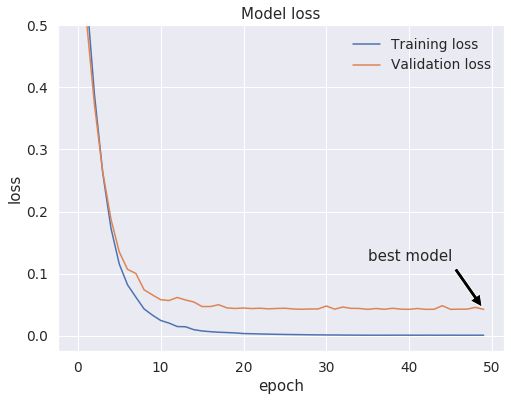

In [5]:
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(8,6))
ax. plot(np.load('data/train_loss.npy'), label="Training loss")
ax. plot(np.load('data/val_loss.npy'), label="Validation loss")
ax.set_title("Model loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.annotate('best model', xy=(np.argmin(np.load('data/val_loss.npy')), min(np.load('data/val_loss.npy'))), xycoords='data', xytext=(35, 0.12), arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_ylim(-0.025,0.5)
ax.legend(frameon=False)
plt.plot();

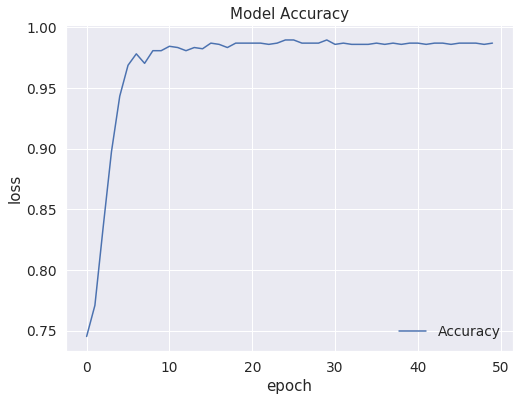

In [6]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8,6))
plt. plot(np.load('data/accuracy.npy'), label="Accuracy")
plt.title("Model Accuracy")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(frameon=False)
plt.plot();

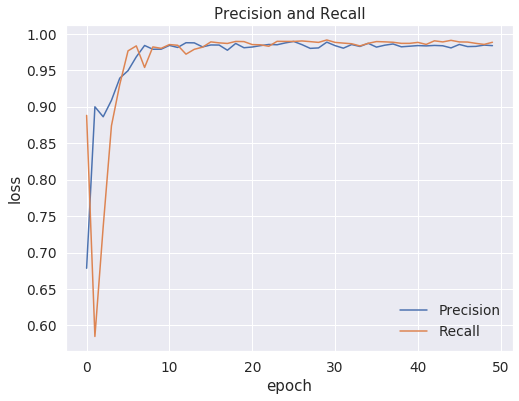

In [7]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8,6))
plt. plot(np.load('data/precision.npy'), label="Precision")
plt. plot(np.load('data/recall.npy'), label="Recall")
plt.title("Precision and Recall")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(frameon=False)
plt.plot();

# Confusion Matrix

In [8]:
model.load_state_dict(torch.load('data/models/best_model.pt'));
model.eval();

FP, FN, TP, TN = num_score(np.load('data/test_pred.npy'), np.load('data/test_label.npy'))
print('FP :', FP, 'FN :', FN, 'TP :', TP, 'TN :', TN)

FP : 0.0 FN : 0.0 TP : 241.0 TN : 259.0


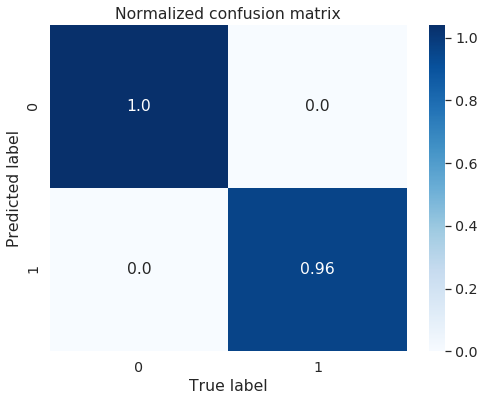

In [9]:
cm = np.array([[TN, FP], [FN, TP]]) / 250.
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
plt.title('Normalized confusion matrix')
sns.heatmap(df_cm.round(2), annot=True, cmap="Blues", fmt='.2')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.plot();

#  Import Sequences and Labels 

In [13]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

# Load sequences
sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())
input_features = np.stack(input_features)
input_features = input_features.transpose(0,2,1).astype(np.float32) # adapt to pytorch input format [N, C, L]

# Load labels
labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences
one_hot_encoder = OneHotEncoder(categories='auto')
input_labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(input_labels).toarray()
input_labels = input_labels.astype(np.float32) # adapt to pytorch input format

# Salient Bases

In [21]:
def compute_saliency_map(model, x):
    """ Evaluate salincy map for the trained model w.r.t class [0, 1]
    """
    X = torch.tensor(x[None]).to(device)
    X_var = torch.autograd.Variable(X, requires_grad=True)
    saliency = None

    model.zero_grad()
    output = model(X_var)
    output.backward(gradient=torch.tensor([[0.,1.]]).to(device)) # gradient w.r.t to class 1

    saliency = X_var.grad.data

    saliency = np.multiply(saliency.cpu().detach().numpy(), X_var.cpu().detach().numpy())
    saliency = np.clip(np.sum(saliency, axis=1), a_min=0, a_max=None)[0]

    return saliency

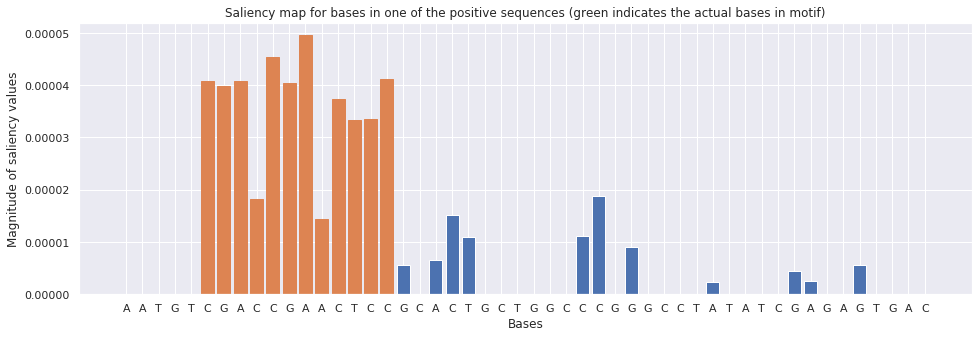

In [22]:
sequence_index = 1999
x = input_features[sequence_index]
saliency  = compute_saliency_map(model, x)

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(saliency)), saliency)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(saliency)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences (green indicates the actual bases in motif)');
